In [110]:
import pandas as pd 
import openpyxl
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
%matplotlib inline

# Data Preparation and Merge 

- TODO: Merge and pull should be done at DAG level

In [111]:
resale_flat_transactions_path = "../data/resale_flats_transformed.csv"
resale_flat_transactions = pd.read_csv(resale_flat_transactions_path)

hdb_info_path = "../data/hdb_information.csv"
hdb_info = pd.read_csv(hdb_info_path)


In [112]:
print(hdb_info.columns)

# head of hdb_info
hdb_info.head()


Index(['year_completed', 'multigen_sold', 'bldg_contract_town',
       'multistorey_carpark', 'street', 'total_dwelling_units', 'blk_no',
       'exec_sold', 'max_floor_lvl', 'residential', '1room_sold',
       'precinct_pavilion', 'other_room_rental', '5room_sold', '3room_sold',
       'commercial', '4room_sold', 'miscellaneous', 'studio_apartment_sold',
       '2room_rental', '2room_sold', '1room_rental', '3room_rental',
       'market_hawker', '_id'],
      dtype='object')


,year_completed,multigen_sold,bldg_contract_town,multistorey_carpark,street,total_dwelling_units,blk_no,exec_sold,max_floor_lvl,residential,...,commercial,4room_sold,miscellaneous,studio_apartment_sold,2room_rental,2room_sold,1room_rental,3room_rental,market_hawker,_id
0,1970,0,KWN,N,BEACH RD,142,1,0,16,Y,...,Y,1,N,0,0,1,0,0,N,1
1,1975,0,BD,N,BEDOK STH AVE 1,206,1,0,14,Y,...,N,0,Y,0,0,0,0,0,N,2
2,2010,0,CT,N,CANTONMENT RD,0,1,0,2,N,...,Y,0,N,0,0,0,0,0,N,3
3,1982,0,BD,N,CHAI CHEE RD,102,1,0,15,Y,...,N,10,N,0,0,0,0,0,N,4
4,1975,0,PRC,N,CHANGI VILLAGE RD,55,1,0,4,Y,...,Y,0,N,0,0,0,0,0,N,5


In [113]:
look_back = 5  # remove after pulling from airflow
resale_flat_transactions = resale_flat_transactions[
    resale_flat_transactions["year"] >= 2023 - look_back
]
print(resale_flat_transactions.shape)

print(resale_flat_transactions.columns)

# head of resale_flat_transactions
resale_flat_transactions.head()


(128453, 20)
Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'remaining_lease', 'lease_commence_date',
       'storey_range', '_id', 'block', 'year', 'street_name_with_block',
       'postal', 'x', 'y', 'lat', 'lon', 'district'],
      dtype='object')


,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,year,street_name_with_block,postal,x,y,lat,lon,district
0,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 1,343000.0,3,56 years 11 months,1981,01 TO 03,147806,330,2023,330 ANG MO KIO AVE 1,560330,29971.149506,38276.316330,1.362432,103.851031,20
1,ANG MO KIO,3 ROOM,New Generation,73.0,ANG MO KIO AVE 1,335000.0,3,53 years 03 months,1977,04 TO 06,147807,319,2023,319 ANG MO KIO AVE 1,560319,29564.949502,38571.105122,1.365098,103.847381,20
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 10,348000.0,3,55 years 05 months,1979,01 TO 03,147808,471,2023,471 ANG MO KIO AVE 10,560471,30602.400746,38390.671921,1.363466,103.856703,20
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,340000.0,3,56 years 11 months,1981,01 TO 03,147809,549,2023,549 ANG MO KIO AVE 10,560549,30681.283561,39463.114437,1.373165,103.857412,20
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 10,390000.0,3,54 years 11 months,1979,07 TO 09,147810,434,2023,434 ANG MO KIO AVE 10,560434,30240.944631,38880.017985,1.367892,103.853455,20


## Primary Key to merge on: full address

In [114]:
# create primary key for resale flat transactions and hdb information
resale_flat_transactions["full_address"] = (
    resale_flat_transactions["block"] + " " + resale_flat_transactions["street_name"]
)
hdb_info["full_address"] = hdb_info["blk_no"] + " " + hdb_info["street"]

# join the resale flat transactions with the hdb information
resale_flat_transactions_new = resale_flat_transactions.merge(
    hdb_info, on="full_address", how="left"
)

print(resale_flat_transactions.shape)
print(resale_flat_transactions_new.shape)


(128453, 21)
(128453, 46)


## District Utils

In [115]:
# drop NIL
resale_flat_transactions_new = resale_flat_transactions_new[
    resale_flat_transactions["district"] != "NIL"
]

# convert district to int
resale_flat_transactions_new["district"] = resale_flat_transactions_new[
    "district"
].astype(int)

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]


# resale_flat_transactions = resale_flat_transactions.merge(district_mapping, left_on="district", right_on="Postal District", how="left")

get_district_name(1)


'Raffles Place, Cecil, Marina, People’s Park'

# Exploratory Data Analysis

### Drop some columns

In [116]:
# aggregate historical data points to historical features
resale_flat_transactions_new.columns

# remove unnecessary columns
# like duplicated columns after merge
# like aggregated columns that leak information about the future
to_remove = [
    "street_name",  # duplicated
    "x",  # duplicated
    "y",  # duplicated
    "street_name_with_block",  # duplicated
    "blk_no",  # duplicated
    "bldg_contract_town",  # duplicated (but not exactly) - town
    "_id_y",  # not needed
    "_id_x",  # not needed
    "_id_y",  # not needed
    "exec_sold",  # leaky
    "1room_rental",  # leaky
    "1room_sold",  # leaky
    "2room_rental",  # leaky
    "2room_sold",  # leaky
    "3room_rental",  # leaky
    "3room_sold",  # leaky
    "4room_sold",  # leaky
    "5room_sold",  # leaky
    "multigen_sold",  # leaky
    "studio_apartment_sold",  # leaky
    "other_room_rental",  # leaky
]
resale_flat_transactions_new = resale_flat_transactions_new.drop(to_remove, axis=1)

print(resale_flat_transactions_new.columns)


Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'resale_price',
       'month', 'remaining_lease', 'lease_commence_date', 'storey_range',
       'block', 'year', 'postal', 'lat', 'lon', 'district', 'full_address',
       'year_completed', 'multistorey_carpark', 'street',
       'total_dwelling_units', 'max_floor_lvl', 'residential',
       'precinct_pavilion', 'commercial', 'miscellaneous', 'market_hawker'],
      dtype='object')


### What do 'commercial', 'residential', 'precinct_pavilion', 'miscellaneous', 'market_hawker' mean?

#### Commercial and Residential

In [117]:
# investigating commerical flats
print(resale_flat_transactions_new["commercial"].value_counts())
print(
    resale_flat_transactions_new[
        resale_flat_transactions_new["commercial"] == "Y"
    ].iloc[0]["full_address"]
)  # commercial means that there are shops in the same building

# investigating residential flats
print(
    resale_flat_transactions_new["residential"].value_counts()
)  # all are residential flats

# remove residential column
resale_flat_transactions_new = resale_flat_transactions_new.drop("residential", axis=1)


N    106514
Y     21787
Name: commercial, dtype: int64
330 ANG MO KIO AVE 1
Y    128301
Name: residential, dtype: int64


![Commercial](../resources/commerical.png)

#### Precint Pavilion

In [118]:
# investigating precinct pavilion
print(resale_flat_transactions_new["precinct_pavilion"].value_counts())

print(
    resale_flat_transactions_new[
        resale_flat_transactions_new["precinct_pavilion"] == "Y"
    ].iloc[2]["full_address"]
)
print(
    resale_flat_transactions_new[
        resale_flat_transactions_new["precinct_pavilion"] == "Y"
    ].iloc[3]["full_address"]
)
print(
    resale_flat_transactions_new[
        resale_flat_transactions_new["precinct_pavilion"] == "Y"
    ].iloc[8]["full_address"]
)


N    127932
Y       369
Name: precinct_pavilion, dtype: int64
63 SIMS PL
717A WOODLANDS DR 70
447B JLN KAYU


![admiraltyvista](../resources/admiralty_vista.png)
![simsplace](../resources/sims_place.png)
![jalankayu](../resources/jalan_kayu.png)

#### Miscellaneous

In [119]:
print(resale_flat_transactions_new["miscellaneous"].value_counts())

# Examples include admin office, childcare centre, education centre, Residents' Committee, etc.
print(
    resale_flat_transactions_new[
        resale_flat_transactions_new["miscellaneous"] == "Y"
    ].iloc[0]["full_address"]
)
print(
    resale_flat_transactions_new[
        resale_flat_transactions_new["miscellaneous"] == "Y"
    ].iloc[2]["full_address"]
)


N    90586
Y    37715
Name: miscellaneous, dtype: int64
319 ANG MO KIO AVE 1
346 ANG MO KIO AVE 3


![319](../resources/319.png)
![346](../resources/346.png)

#### Market Hawker

In [120]:
print(resale_flat_transactions_new["market_hawker"].value_counts(), "\n")

print(
    "transactions with market hawker",
    resale_flat_transactions_new[resale_flat_transactions_new["market_hawker"] == "Y"][
        "street"
    ].value_counts(),
    "\n",
)
# only 1 street has market hawker?
# transactions involving only 1 street has market_hawker
# => transactions with market_hawker == True are rare

print(
    "hdb info market hawker distribution \n", hdb_info["market_hawker"].value_counts()
)  # market hawker are rare but not that rare as in resale flat transactions

# should not remove market_hawker column because it may be a useful featurea


N    128292
Y         9
Name: market_hawker, dtype: int64 

transactions with market hawker NEW MKT RD    9
Name: street, dtype: int64 

hdb info market hawker distribution 
 N    12517
Y      109
Name: market_hawker, dtype: int64


![newmkt](../resources/newmkt.png)

#### Multistory Carpark

In [121]:
print(resale_flat_transactions_new["multistorey_carpark"].value_counts(), "\n")

print(
    resale_flat_transactions_new[
        resale_flat_transactions_new["multistorey_carpark"] == "Y"
    ]["street"].value_counts(),
    "\n",
)
# transactions involving only 2 streets has multistorey carpark
# => transactions with multistorey_carpark == True are rare

print(
    "hdb info multistorey carpark distribution \n",
    hdb_info["multistorey_carpark"].value_counts(),
)  # multi storey carparks aren't that rare in general

# should not remove multistorey_carpark column because it may be a useful feature
# it may signal that flats with multi storey carparks are significantly more expensive during listing, transaction does not go through


N    128276
Y        25
Name: multistorey_carpark, dtype: int64 

CHOA CHU KANG AVE 2    23
SERANGOON CTRL DR       2
Name: street, dtype: int64 

hdb info multistorey carpark distribution 
 N    11571
Y     1055
Name: multistorey_carpark, dtype: int64


![multistorey_carpark](../resources/multistorey_carpark.png)

### Remaining Categorical Features

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'resale_price',
       'month', 'remaining_lease', 'lease_commence_date', 'storey_range',
       'block', 'year', 'postal', 'lat', 'lon', 'district', 'full_address',
       'year_completed', 'multistorey_carpark', 'street',
       'total_dwelling_units', 'max_floor_lvl', 'precinct_pavilion',
       'commercial', 'miscellaneous', 'market_hawker'],
      dtype='object')


/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_31150/2300431846.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


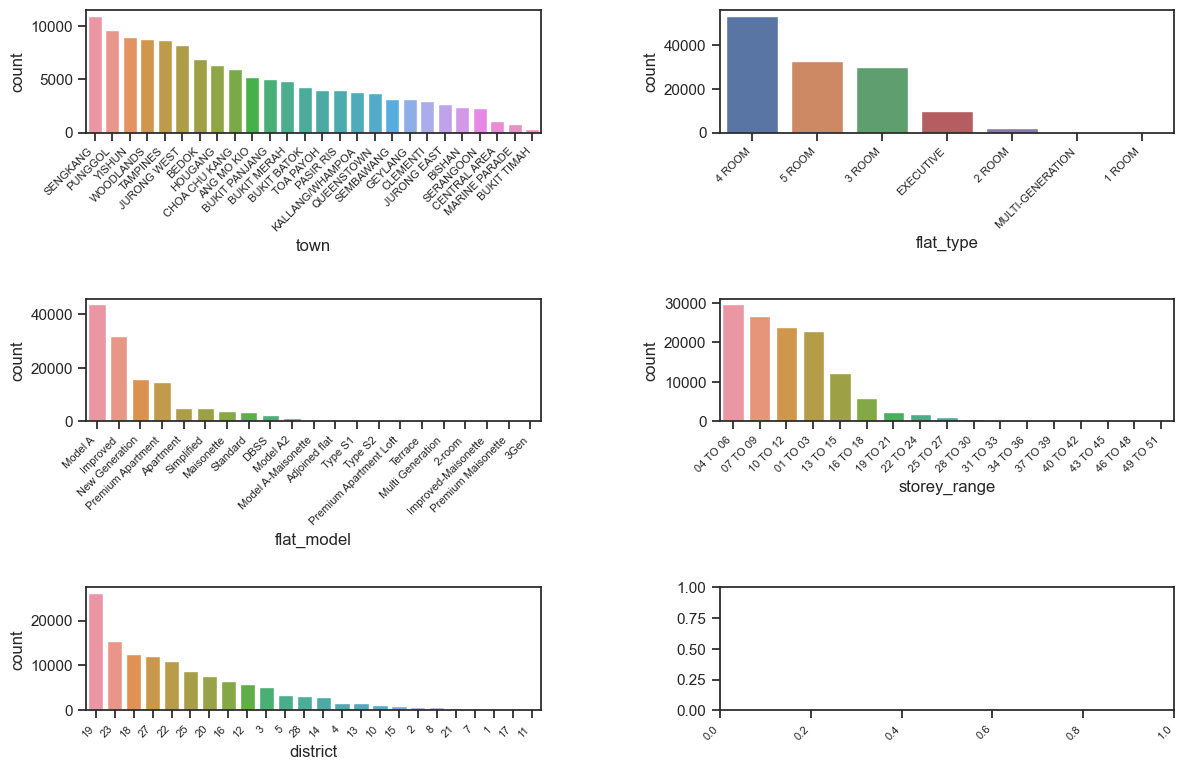

In [122]:
print(resale_flat_transactions_new.columns)

remaining_categorical_features = [
    "town",
    "flat_type",
    "flat_model",
    "storey_range",
    # 'street', -> too many streets
    # 'block', -> too many blocks
    "district"
    # 'commercial',
    # 'precinct_pavilion',
    # 'miscellaneous',
    # 'market_hawker'
]

# plot countplot for all categorical features
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 10))
fig.tight_layout(pad=8.0)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, feature in enumerate(remaining_categorical_features):
    sns.countplot(
        x=feature,
        data=resale_flat_transactions_new,
        order=resale_flat_transactions_new[feature].value_counts().index,
        ax=axes[i],
    )

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    # reduce label font size
    for label in ax.get_xticklabels():
        label.set_fontsize(8)
plt.show()


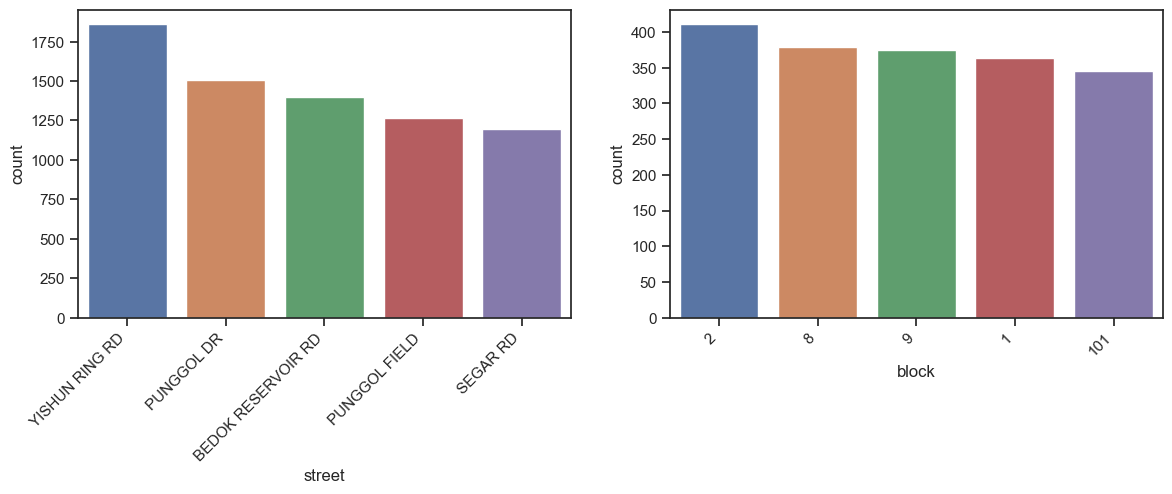

In [123]:
# plot street and block separately
fig, ((ax7, ax8)) = plt.subplots(1, 2, figsize=(14, 4))


# top 5 streets
top_5_streets = resale_flat_transactions_new["street"].value_counts().index[:5]
top_5_streets_df = resale_flat_transactions_new[
    resale_flat_transactions_new["street"].isin(top_5_streets)
]
sns.countplot(
    x="street",
    data=top_5_streets_df,
    order=top_5_streets_df["street"].value_counts().index,
    ax=ax7,
)

# top 5 blocks
top_5_blocks = resale_flat_transactions_new["block"].value_counts().index[:5]
top_5_blocks_df = resale_flat_transactions_new[
    resale_flat_transactions_new["block"].isin(top_5_blocks)
]
sns.countplot(
    x="block",
    data=top_5_blocks_df,
    order=top_5_blocks_df["block"].value_counts().index,
    ax=ax8,
)

for ax in (ax7, ax8):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

# yishun ?


### Numerical Features

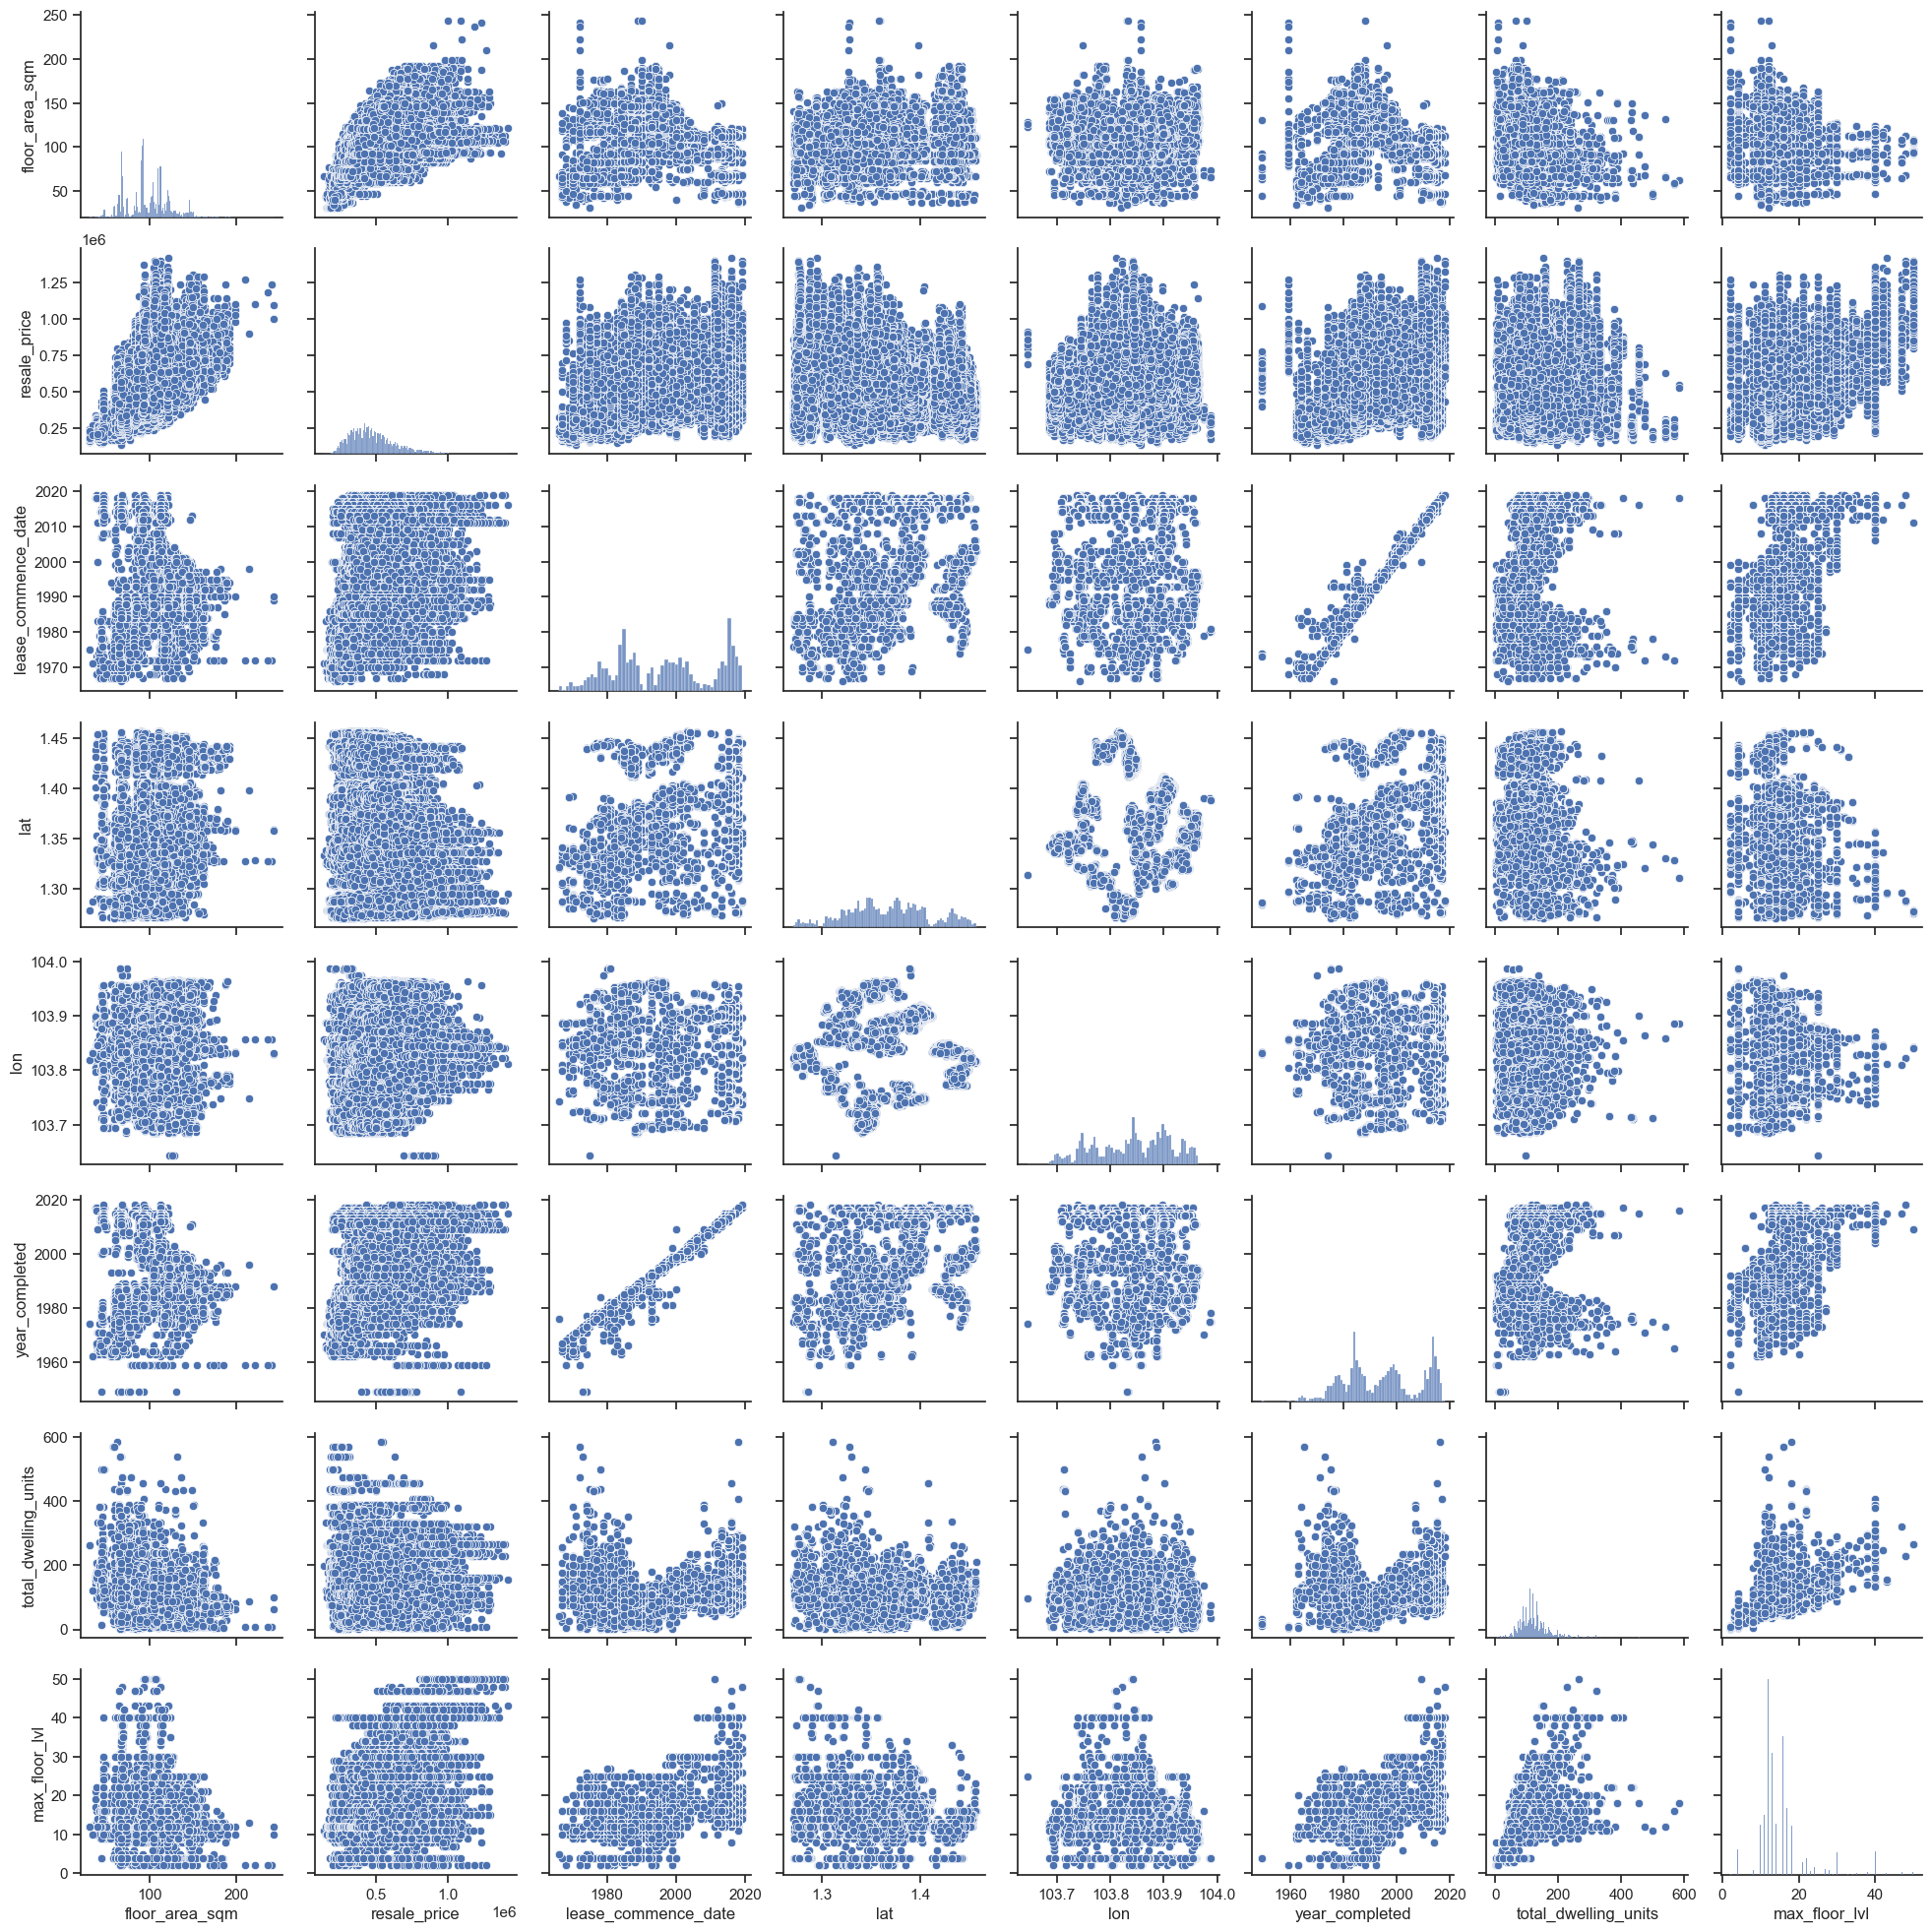

In [124]:
# plot the distribution of the remaining features with seaborn (non-categorical features, year, month)
sns.set(style="ticks", color_codes=True)
sns.pairplot(
    resale_flat_transactions_new.drop(
        remaining_categorical_features + ["year", "month"], axis=1
    )
)


### Drop more columns after correlation analysis

In [125]:
# lease_commence_date is always one year after year_completed 
print(resale_flat_transactions_new[['lease_commence_date', 'year_completed']].head())

# remove year_completed 
resale_flat_transactions_new = resale_flat_transactions_new.drop('year_completed', axis=1)

# lease_commence_date and remaining_lease are perfectly correlated, which makes sense 
# remove lease_commence_date
resale_flat_transactions_new = resale_flat_transactions_new.drop('lease_commence_date', axis=1)

   lease_commence_date  year_completed
0                 1981            1980
1                 1977            1976
2                 1979            1978
3                 1981            1980
4                 1979            1978


### Save to CSV

In [126]:
resale_flat_transactions_new.columns

resale_flat_transactions_new.to_csv('../data/resale_flat_transactions_clean.csv', index=False)

# Time Series Analysis and Forecasting

- Target: Median resale price of each district over time (months)

## Get TS

In [201]:
resale_flat_transactions_clean = pd.read_csv(
    "../data/resale_flat_transactions_clean.csv"
)

# aggregate resale flat transactions by district and time (month and year)
resale_flat_transactions_clean["month_year"] = (
    resale_flat_transactions_clean["month"].astype(str)
    + "-"
    + resale_flat_transactions_clean["year"].astype(str)
)
resale_flat_transactions_clean["month_year"] = pd.to_datetime(
    resale_flat_transactions_new["month_year"], format="%m-%Y"
)  # assume first day of month for illustration purposes
resale_flat_transactions_clean = resale_flat_transactions_clean.drop(
    ["month", "year"], axis=1
)

# groupby district and month_year and take median of resale_price
resale_flat_transactions_clean = (
    resale_flat_transactions_clean.groupby(["district", "month_year"])
    .agg({"resale_price": "median"})
    .reset_index()
)

resale_flat_transactions_clean.head()


,district,month_year,resale_price
0,1,2019-07-01,450000.0
1,2,2018-12-01,858888.0
2,2,2019-01-01,850000.0
3,2,2019-02-01,888000.0
4,2,2019-09-01,464000.0


## Plot TS

In [211]:
# Number of districts
num_districts = len(resale_flat_transactions_clean['district'].value_counts())

districts = resale_flat_transactions_clean["district"].unique().tolist()

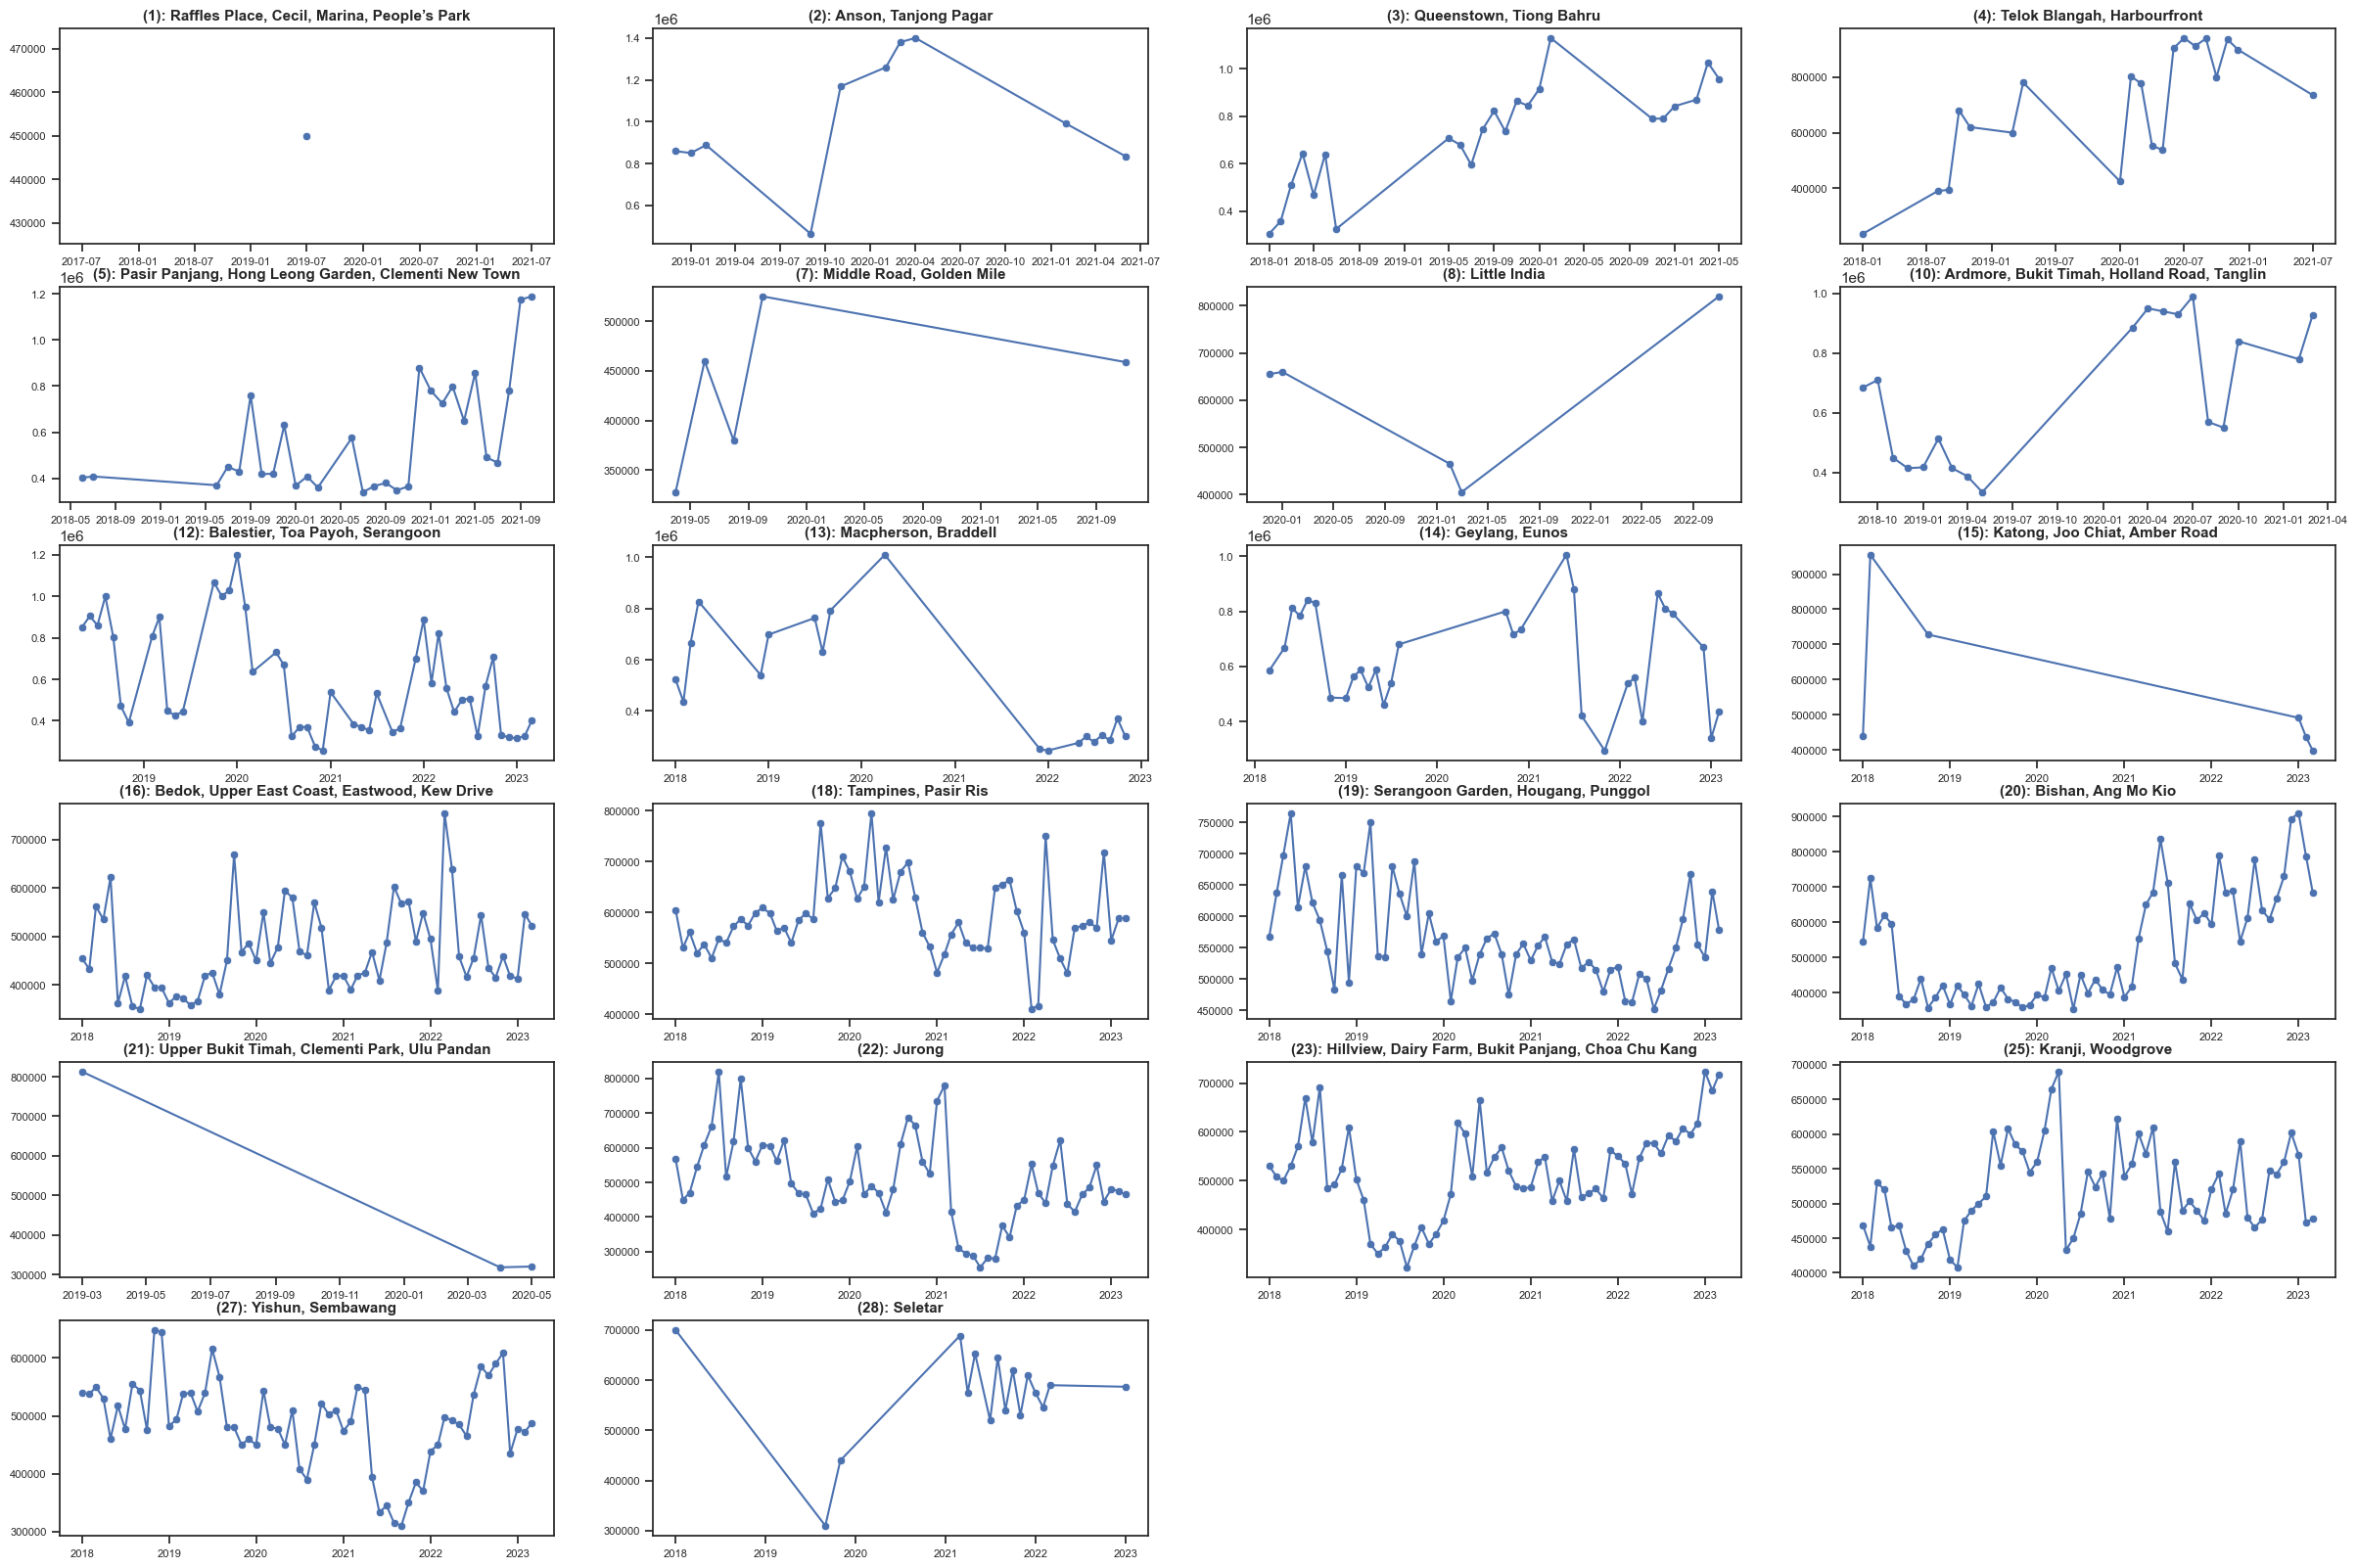

In [213]:
# plot time series of resale price by district
fig = plt.figure(figsize=(30, 20))
fig.tight_layout(pad=20)

for i in range(num_districts):
    curr_district = districts[i]
    plt.subplot(6, 4, i + 1)
    district_df = resale_flat_transactions_clean[
        resale_flat_transactions_clean["district"]
        == curr_district
    ]
    sns.lineplot(x="month_year", y="resale_price", data=district_df) 
    # add points
    sns.scatterplot(x="month_year", y="resale_price", data=district_df)  
    # xlabel 45
    # plt.xticks(rotation=45)
    # remove xlabel
    plt.xlabel("")
    # remove ylabel
    plt.ylabel("")
    # reduce label font size
    for label in plt.gca().get_xticklabels():
        label.set_fontsize(8)
    # reduce y label font size
    for label in plt.gca().get_yticklabels():
        label.set_fontsize(8)
    title = plt.title(
        f'({curr_district}): ' + get_district_name(curr_district),
        fontsize=11,
        fontweight="bold"
    )

plt.show()


In [203]:
# low volume districts 
low_volume_districts = [
    1, # Raffles Place, Cecil, Marina, People's Park
    2, # Anson, Tanjong Pagar
    
]

# sanity check on these low volume districts
for district in low_volume_districts:
    district_df = resale_flat_transactions_clean[
        resale_flat_transactions_clean["district"] == district
    ]
    print(district_df.shape)

resale_flat_transactions_clean[resale_flat_transactions_clean['district'] == 0]
    

(0, 3)
(1, 3)
(29, 3)
(0, 3)
(5, 3)
(0, 3)
(0, 3)
(63, 3)


,district,month_year,resale_price


In [204]:
resale_flat_transactions_clean['district'].unique()

array([ 1,  2,  3,  4,  5,  7,  8, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21,
       22, 23, 25, 27, 28])